# Tranlation Matrix Tutorial

## What is it ?

Suppose we are given a setofword pairs and their associated vector representaion $\{x_{i},z_{i}\}_{i=1}^{n}$, where $x_{i} \in R^{d_{1}}$ is the distibuted representation of word $i$ in the source language, and ${z_{i} \in R^{d_{2}}}$ is the vector representation of its translation. Our goal is to find a transformation matrix $W$ such that $Wx_{i}$ approximates $z_{i}$. In practice, $W$ can be learned by the following optimization prolem:

<center>$\min \limits_{W} \sum \limits_{i=1}^{n} ||Wx_{i}-z_{i}||^{2}$</center>

## Resources

Tomas Mikolov, Quoc V Le, Ilya Sutskever. 2013.[Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168.pdf)

Georgiana Dinu, Angelikie Lazaridou and Marco Baroni. 2014.[Improving zero-shot learning by mitigating the hubness problem](https://arxiv.org/pdf/1309.4168.pdf)

In [1]:
import os

from gensim import utils
from gensim.models import translation_matrix
from gensim.models import KeyedVectors

Using Theano backend.


For this tutorial, we'll be training our model using the English -> Italian word pairs from the OPUS collection. This corpus contains 5000 word pairs. Each pair is a English word and corresponding Italian word.

dataset download: 

[OPUS_en_it_europarl_train_5K.txt](https://pan.baidu.com/s/1nuIuQoT)

In [2]:
train_file = "OPUS_en_it_europarl_train_5K.txt"

with utils.smart_open(train_file, "r") as f:
    word_pair = [tuple(utils.to_unicode(line).strip().split()) for line in f]
print word_pair[:10]

[(u'for', u'per'), (u'that', u'che'), (u'with', u'con'), (u'are', u'are'), (u'are', u'sono'), (u'this', u'questa'), (u'this', u'questo'), (u'you', u'lei'), (u'not', u'non'), (u'which', u'che')]


This tutorial uses 300-dimensional vectors of English words as source and vectors of Italian words as target.(those vector trained by the word2vec toolkit with cbow. The context window was set 5 words to either side of the target,
the sub-sampling option was set to 1e-05 and estimate the probability of a target word with the negative sampling method, drawing 10 samples from the noise distribution)

dataset download:

[EN.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt](https://pan.baidu.com/s/1nv3bYel)

[IT.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt](https://pan.baidu.com/s/1boP0P7D)

In [3]:
# Load the source language word vector
source_word_vec_file = "EN.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt"
source_word_vec = KeyedVectors.load_word2vec_format(source_word_vec_file, binary=False)

In [4]:
#Load the target language word vector
target_word_vec_file = "IT.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt"
target_word_vec = KeyedVectors.load_word2vec_format(target_word_vec_file, binary=False)

training the translation matrix

In [5]:
transmat = translation_matrix.TranslationMatrix(word_pair, source_word_vec, target_word_vec)
transmat.train(word_pair)
print "the shape of translation matrix is: ", transmat.translation_matrix.shape

the shape of translation matrix is:  (300, 300)


Prediction Time: for any given new word, we can map it to the other language space by coputing $z = Wx$, then we find the word whose representation is closet to z in the target language space, using consine similarity as the distance metric.

#### part one:
Let's look at some number translation. We use English words (one, two, three, four and five) as test.

In [6]:
words = [("one", "uno"), ("two", "due"), ("three", "tre"), ("four", "quattro"), ("five", "cinque")]
source_word, target_word = zip(*words)
translated_word = transmat.translate(source_word, 5)

/home/robotcator/PycharmProjects/gensim/gensim/models/translation_matrix.py:213: UserWarning: The parameter source_lang_vec didn't specified, use the model's source language word vector as default
  warnings.warn("The parameter source_lang_vec didn't specified, use the model's source language word vector as default")
/home/robotcator/PycharmProjects/gensim/gensim/models/translation_matrix.py:217: UserWarning: The parameter target_lang_vec isn't specified, use the model's target language word vector as default
  warnings.warn("The parameter target_lang_vec isn't specified, use the model's target language word vector as default")


In [7]:
for k, v in translated_word.iteritems():
    print "word ", k, " and translated word", v

word  one  and translated word [u'solo', u'due', u'tre', u'cinque', u'quattro']
word  two  and translated word [u'due', u'tre', u'quattro', u'cinque', u'otto']
word  three  and translated word [u'tre', u'quattro', u'due', u'cinque', u'sette']
word  four  and translated word [u'tre', u'quattro', u'cinque', u'due', u'sette']
word  five  and translated word [u'cinque', u'tre', u'quattro', u'otto', u'dieci']


#### part two:
Let's look at some fruit translations. We use English words (apple, orange, grape, banana and mango) as test.

In [8]:
words = [("apple", "mela"), ("orange", "arancione"), ("grape", "acino"), ("banana", "banana"), ("mango", "mango")]
source_word, target_word = zip(*words)
translated_word = transmat.translate(source_word, 5)
for k, v in translated_word.iteritems():
    print "word ", k, " and translated word", v

word  apple  and translated word [u'apple', u'mela', u'microsoft', u'macintosh', u'turbolinux']
word  orange  and translated word [u'arancione', u'curacao', u'aranciato', u'gialloarancio', u'bluastro']
word  grape  and translated word [u'sylvaner', u'vinsanto', u'marzemino', u'traminer', u'legume']
word  banana  and translated word [u'anacardi', u'papaia', u'muesli', u'manioca', u'basmati']
word  mango  and translated word [u'patchouli', u'anacardi', u'papaia', u'tamarindo', u'guacamole']


#### part three:
Let's look at some animal translations. We use English words (dog, pig, cat, horse and bird) as test.

In [9]:
words = [("dog", "cane"), ("pig", "maiale"), ("cat", "gatto"), ("fish", "cavallo"), ("birds", "uccelli")]
source_word, target_word = zip(*words)
translated_word = transmat.translate(source_word, 5)
for k, v in translated_word.iteritems():
    print "word ", k, " and translated word", v

word  dog  and translated word [u'cane', u'cani', u'cagnolino', u'barboncino', u'micio']
word  pig  and translated word [u'maiali', u'maialini', u'animale', u'barboncino', u'vitella']
word  cat  and translated word [u'gatto', u'gattino', u'micio', u'cagnolino', u'cane']
word  fish  and translated word [u'krill', u'pesce', u'pesci', u'storioni', u'alborelle']
word  birds  and translated word [u'uccelli', u'passeriformi', u'antilopi', u'rettili', u'svassi']


### The Creation Time for the Translation Matrix

Testing the creation time, we extracted more word pairs from a dictionary built from Europarl([Europara, en-it](http://opus.lingfil.uu.se/)).we obtain about 20K word pairs and their coresponding word vectors.Or you can download from this.[word_dict.pkl](https://pan.baidu.com/s/1dF8HUX7)

In [10]:
import pickle
word_dict = "word_dict.pkl"
with utils.smart_open(word_dict, "r") as f:
    word_pair = pickle.load(f)
print "the length of word pair ", len(word_pair)

the length of word pair  20942


In [11]:
import time

test_case = 10
word_pair_length = len(word_pair)
step = word_pair_length / test_case

duration = []
sizeofword = []

for idx in xrange(0, test_case):
    sub_pair = word_pair[: (idx + 1) * step]

    startTime = time.time()
    transmat = translation_matrix.TranslationMatrix(sub_pair, source_word_vec, target_word_vec)
    transmat.train(sub_pair)
    endTime = time.time()
    
    sizeofword.append(len(sub_pair))
    duration.append(endTime - startTime)

In [12]:
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [Scatter(x=sizeofword, y=duration)],
    "layout": Layout(title="time for creation"),
}, filename="tm_creation_time.html")

### Linear Relationship Between Languages

To have a better understanding of the principles behind, we visualized the word vectors using PCA, we noticed that the vector representations of similar words in different languages were related by a linear transformation.

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pylab import rcParams 
rcParams['figure.figsize'] = 16, 10

import plotly
from plotly.graph_objs import Scatter, Layout, Figure
plotly.offline.init_notebook_mode(connected=True)

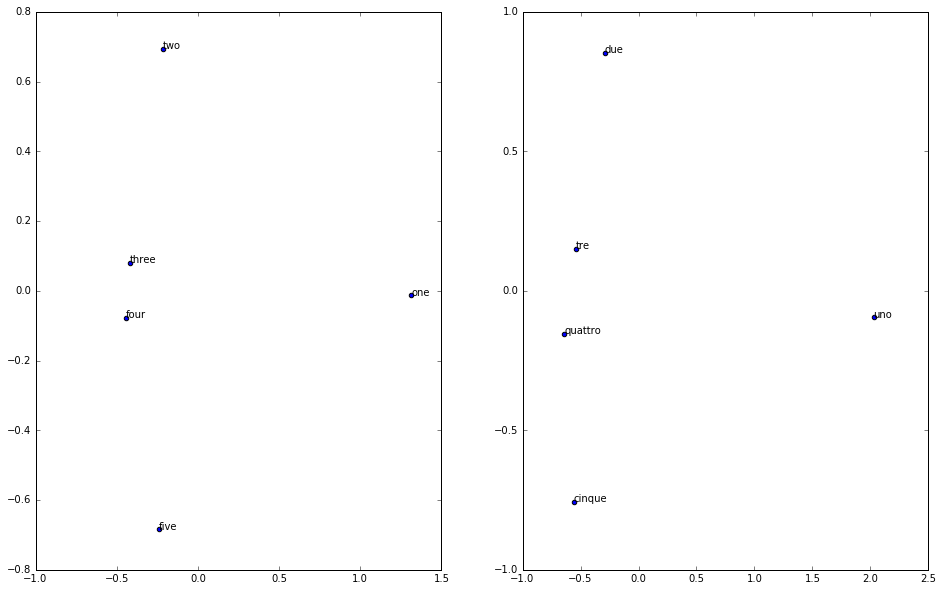

In [14]:
words = [("one", "uno"), ("two", "due"), ("three", "tre"), ("four", "quattro"), ("five", "cinque")]
en_words_vec = [source_word_vec[item[0]] for item in words]
it_words_vec = [target_word_vec[item[1]] for item in words]

en_words, it_words = zip(*words)

pca = PCA(n_components=2)
new_en_words_vec = pca.fit_transform(en_words_vec)
new_it_words_vec = pca.fit_transform(it_words_vec)

fig = plt.figure()
fig.add_subplot(121)
plt.scatter(new_en_words_vec[:, 0], new_en_words_vec[:, 1])
for idx, item in enumerate(en_words):
    plt.annotate(item, xy=(new_en_words_vec[idx][0], new_en_words_vec[idx][1]))

fig.add_subplot(122)
plt.scatter(new_it_words_vec[:, 0], new_it_words_vec[:, 1])
for idx, item in enumerate(it_words):
    plt.annotate(item, xy=(new_it_words_vec[idx][0], new_it_words_vec[idx][1]))
plt.show()

In [15]:
# you can also using plotly lib to plot in one figure
trace1 = Scatter(
    x=new_en_words_vec[:, 0],
    y= new_en_words_vec[:, 1],
    mode='markers+text',
    text=en_words,
    textposition='top'
)
trace2 = Scatter(
    x=new_it_words_vec[:, 0],
    y= new_it_words_vec[:, 1],
    mode='markers+text',
    text=it_words,
    textposition='top'
)
layout = Layout(
    showlegend=False
)
data = [trace1, trace2]

fig = Figure(data=data, layout=layout)
plot_url = plotly.offline.iplot(fig, filename='relatie_position_for_number.html')

The figure shows that the word vectors for English number one to five and the corresponding Italian words uno to cinque have similar geometric arrangements. So the relationship between vector spaces that represent these tow languages can be captured by linear mapping. 
If we know the translation of one and four from English to Spanish, we can learn the transformation matrix that can help us to translate five or other numbers.

translation of five:  OrderedDict([('five', [u'cinque', u'quattro', u'tre'])])


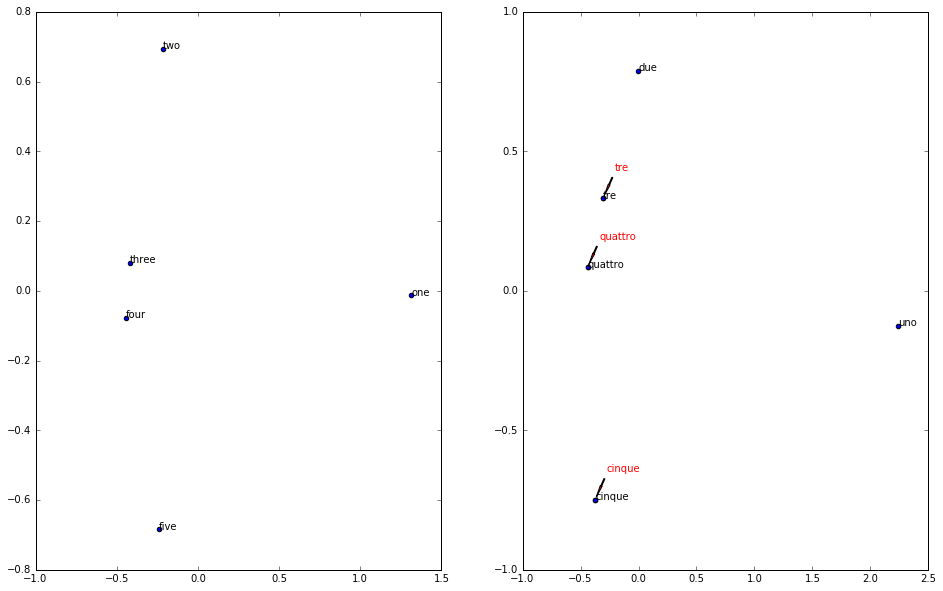

In [16]:
words = [("one", "uno"), ("two", "due"), ("three", "tre"), ("four", "quattro"), ("five", "cinque")]
en_words, it_words = zip(*words)
en_words_vec = [source_word_vec[item[0]] for item in words]
it_words_vec = [target_word_vec[item[1]] for item in words]

# translate the English word five to Spanish
translated_word = transmat.translate([en_words[4]], 3)
print "translation of five: ", translated_word

# the translated words of five
for item in translated_word[en_words[4]]:
    it_words_vec.append(target_word_vec[item])

pca = PCA(n_components=2)
new_en_words_vec = pca.fit_transform(en_words_vec)
new_it_words_vec = pca.fit_transform(it_words_vec)

fig = plt.figure()
fig.add_subplot(121)
plt.scatter(new_en_words_vec[:, 0], new_en_words_vec[:, 1])
for idx, item in enumerate(en_words):
    plt.annotate(item, xy=(new_en_words_vec[idx][0], new_en_words_vec[idx][1]))

fig.add_subplot(122)
plt.scatter(new_it_words_vec[:, 0], new_it_words_vec[:, 1])
for idx, item in enumerate(it_words):
    plt.annotate(item, xy=(new_it_words_vec[idx][0], new_it_words_vec[idx][1]))
# annote for the translation of five, the red text annotation is the translation of five
for idx, item in enumerate(translated_word[en_words[4]]):
    plt.annotate(item, xy=(new_it_words_vec[idx+5][0], new_it_words_vec[idx+5][1]),
                 xytext=(new_it_words_vec[idx+5][0]+0.1, new_it_words_vec[idx+5][1]+0.1),
                 color="red",
                 arrowprops=dict(facecolor='red', shrink=0.1, width=1, headwidth=2),)
plt.show()

In [17]:
trace1 = Scatter(
    x=new_en_words_vec[:, 0],
    y=new_en_words_vec[:, 1],
    mode='markers+text',
    textposition='top'
)
trace2 = Scatter(
    x=new_it_words_vec[:, 0],
    y=new_it_words_vec[:, 1],
    mode='markers+text',
    text=it_words,
    textposition='top'
)
layout = Layout(
    showlegend=False,
    annotations = [dict(
        x = new_it_words_vec[5][0],
        y = new_it_words_vec[5][1],
        text = translated_word[en_words[4]][0],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      ), dict(
        x = new_it_words_vec[6][0],
        y = new_it_words_vec[6][1],
        text = translated_word[en_words[4]][1],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      ), dict(
        x = new_it_words_vec[7][0],
        y = new_it_words_vec[7][1],
        text = translated_word[en_words[4]][2],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      )]
)
data = [trace1, trace2]

fig = Figure(data=data, layout=layout)
plot_url = plotly.offline.iplot(fig, filename='relatie_position_for_numbers.html')

Let's see some animals word, the figue show that most of words are also share the similar geometric arrangements.

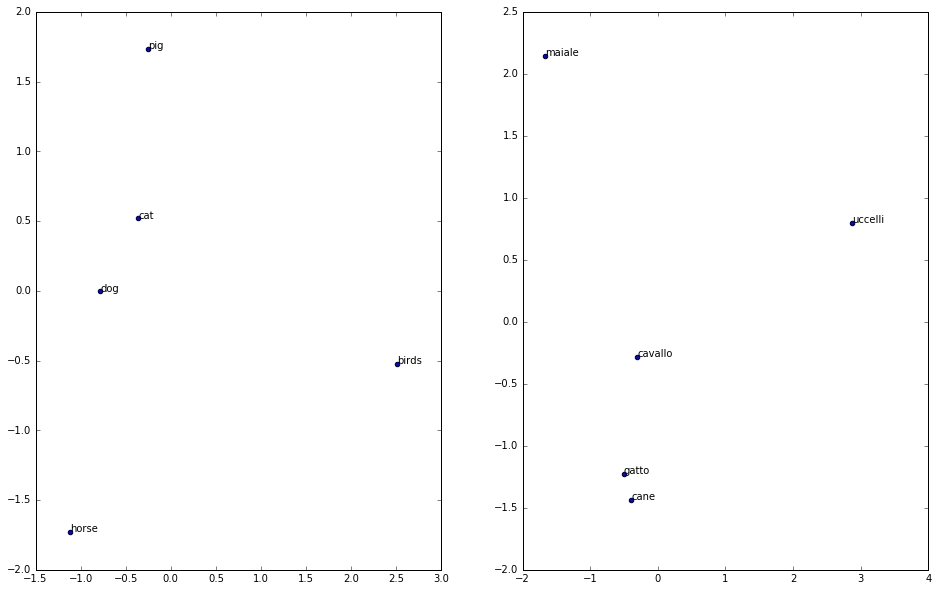

In [18]:
words = [("dog", "cane"), ("pig", "maiale"), ("cat", "gatto"), ("horse", "cavallo"), ("birds", "uccelli")]
en_words_vec = [source_word_vec[item[0]] for item in words]
it_words_vec = [target_word_vec[item[1]] for item in words]

en_words, it_words = zip(*words)

pca = PCA(n_components=2)
new_en_words_vec = pca.fit_transform(en_words_vec)
new_it_words_vec = pca.fit_transform(it_words_vec)

fig = plt.figure()
fig.add_subplot(121)
plt.scatter(new_en_words_vec[:, 0], new_en_words_vec[:, 1])
for idx, item in enumerate(en_words):
    plt.annotate(item, xy=(new_en_words_vec[idx][0], new_en_words_vec[idx][1]))

fig.add_subplot(122)
plt.scatter(new_it_words_vec[:, 0], new_it_words_vec[:, 1])
for idx, item in enumerate(it_words):
    plt.annotate(item, xy=(new_it_words_vec[idx][0], new_it_words_vec[idx][1]))
plt.show()

In [19]:
trace1 = Scatter(
    x=new_en_words_vec[:, 0],
    y= new_en_words_vec[:, 1],
    mode='markers+text',
    text=en_words,
    textposition='top'
)
trace2 = Scatter(
    x=new_it_words_vec[:, 0],
    y= new_it_words_vec[:, 1],
    mode='markers+text',
    text=it_words,
    textposition='top'
)
layout = Layout(
    showlegend=False
)
data = [trace1, trace2]

fig = Figure(data=data, layout=layout)
plot_url = plotly.offline.iplot(fig, filename='relatie_position_for_animal.html')

translation of birds:  OrderedDict([('birds', [u'uccelli', u'garzette', u'iguane'])])


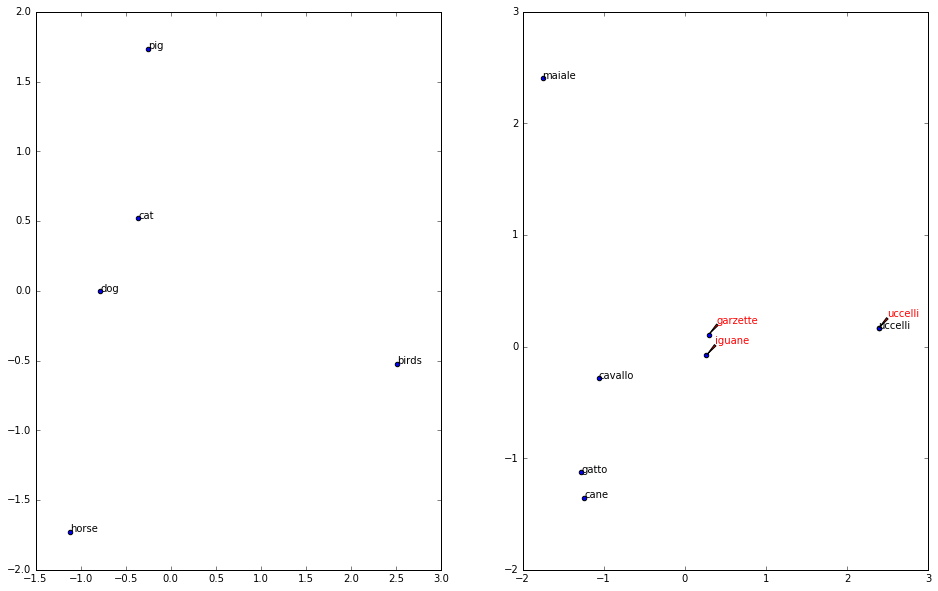

In [20]:
words = [("dog", "cane"), ("pig", "maiale"), ("cat", "gatto"), ("horse", "cavallo"), ("birds", "uccelli")]
en_words, it_words = zip(*words)
en_words_vec = [source_word_vec[item[0]] for item in words]
it_words_vec = [target_word_vec[item[1]] for item in words]

# translate the English word birds to Spanish
translated_word = transmat.translate([en_words[4]], 3)
print "translation of birds: ", translated_word

# the translated words of birds
for item in translated_word[en_words[4]]:
    it_words_vec.append(target_word_vec[item])

pca = PCA(n_components=2)
new_en_words_vec = pca.fit_transform(en_words_vec)
new_it_words_vec = pca.fit_transform(it_words_vec)


fig = plt.figure()
fig.add_subplot(121)
plt.scatter(new_en_words_vec[:, 0], new_en_words_vec[:, 1])
for idx, item in enumerate(en_words):
    plt.annotate(item, xy=(new_en_words_vec[idx][0], new_en_words_vec[idx][1]))

fig.add_subplot(122)
plt.scatter(new_it_words_vec[:, 0], new_it_words_vec[:, 1])
for idx, item in enumerate(it_words):
    plt.annotate(item, xy=(new_it_words_vec[idx][0], new_it_words_vec[idx][1]))
# annote for the translation of five, the red text annotation is the translation of five
for idx, item in enumerate(translated_word[en_words[4]]):
    plt.annotate(item, xy=(new_it_words_vec[idx+5][0], new_it_words_vec[idx+5][1]),
                 xytext=(new_it_words_vec[idx+5][0]+0.1, new_it_words_vec[idx+5][1]+0.1),
                 color="red",
                 arrowprops=dict(facecolor='red', shrink=0.1, width=1, headwidth=2),)
plt.show()

In [21]:
trace1 = Scatter(
    x=new_en_words_vec[:, 0],
    y=new_en_words_vec[:, 1],
    mode='markers+text',
    text=en_words,
    textposition='top'
)
trace2 = Scatter(
    x=new_it_words_vec[:5, 0],
    y=new_it_words_vec[:5, 1],
    mode='markers+text',
    text=it_words[:5],
    textposition='top'
)
layout = Layout(
    showlegend=False,
    annotations = [dict(
        x = new_it_words_vec[5][0],
        y = new_it_words_vec[5][1],
        text = translated_word[en_words[4]][0],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      ), dict(
        x = new_it_words_vec[6][0],
        y = new_it_words_vec[6][1],
        text = translated_word[en_words[4]][1],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      ), dict(
        x = new_it_words_vec[7][0],
        y = new_it_words_vec[7][1],
        text = translated_word[en_words[4]][2],
        arrowcolor = "black",
        arrowsize = 1.5,
        arrowwidth = 1,
        arrowhead = 0.5
      )]
)
data = [trace1, trace2]

fig = Figure(data=data, layout=layout)
plot_url = plotly.offline.iplot(fig, filename='relatie_position_for_animal.html')